# ML based computer vision indoor climbing analysis
 
In this ML analysis, we implement a sequential detection strategy:
- First, hold detection is performed using a YOLOv8 Detection model to retrieve the climbing holds.
- Then, color detection is applied using a fine-tuned Vision Transformer (ViT) multi-label classification model to classify the holds by their color, helping to identify different routes.
 
These models have been fine-tuned on both color and hold datasets of indoor climbing holds to achieve superior performance compared to traditional computer vision techniques.



image 1/1 /Users/gabrielemasciulli/Desktop/uni/master/1°st year/1°st semester/Image Signal Processsing/Project/immagini test/IMG_006.jpg: 480x640 142 0s, 52.4ms
Speed: 1.7ms preprocess, 52.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Coordinates of holds: [[ 535  997  710 1209]
 [1003 1012 1157 1180]
 [ 902  905 1026 1083]
 [1684  985 1913 1215]
 [ 415 1136  585 1298]
 [1560  363 1719  465]
 [1834  585 2017  743]
 [1678  270 1837  378]
 [ 996  537 1163  671]
 [1490  740 1699  903]
 [ 395  316  564  480]
 [ 680  384  835  549]
 [1119  759 1239  871]
 [ 349 1029  494 1146]
 [ 628  675  735  756]
 [  65  902  182 1020]
 [1239 1036 1374 1152]
 [ 108   83  297  184]
 [ 563  560  668  654]
 [1292 1281 1376 1376]
 [1368 1126 1534 1239]
 [1382  204 1495  272]
 [ 504  222  706  333]
 [1794 1266 1923 1388]
 [1439  489 1590  571]
 [1168 1406 1281 1511]
 [1711 1416 1835 1527]
 [ 131  423  254  567]
 [ 481  713  676  820]
 [1189  528 1330  741]
 [ 363  477  462  595]
 [ 739

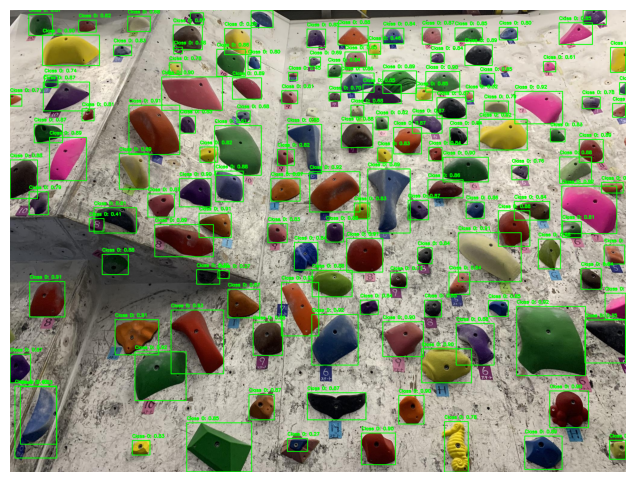

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO("./weights/hold_weights.pt")  

# Load the image
image_path = "./immagini test/IMG_006.jpg"  
image = cv2.imread(image_path)

# Convert from BGR to RGB for Matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run inference
results = model(image_path)

# Define colors and font
color = (0, 255, 0)  # Green color for bounding boxes

# Create an array to hold all coordinates of the holds
hold_coordinates = []

# Process results
for result in results:
    for box in result.boxes:
        # Convert tensor values to readable format
        class_id = int(box.cls.item())  # Class ID
        confidence = float(box.conf.item())  # Confidence score
        x1, y1, x2, y2 = map(int, box.xyxy.cpu().numpy().flatten())  # Coordinates

        # Append the hold coordinates to the array
        hold_coordinates.append([x1, y1, x2, y2])

        # Draw bounding box
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), color, 2)

        # Label with class and confidence
        label = f"Class {class_id}: {confidence:.2f}"
        cv2.putText(image_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Optionally convert the list to a numpy array if needed
hold_coordinates = np.array(hold_coordinates)
print("Coordinates of holds:", hold_coordinates)

# Plot image using Matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")  # Hide axes
plt.show()


Processing holds: 100%|██████████| 142/142 [01:25<00:00,  1.67it/s]


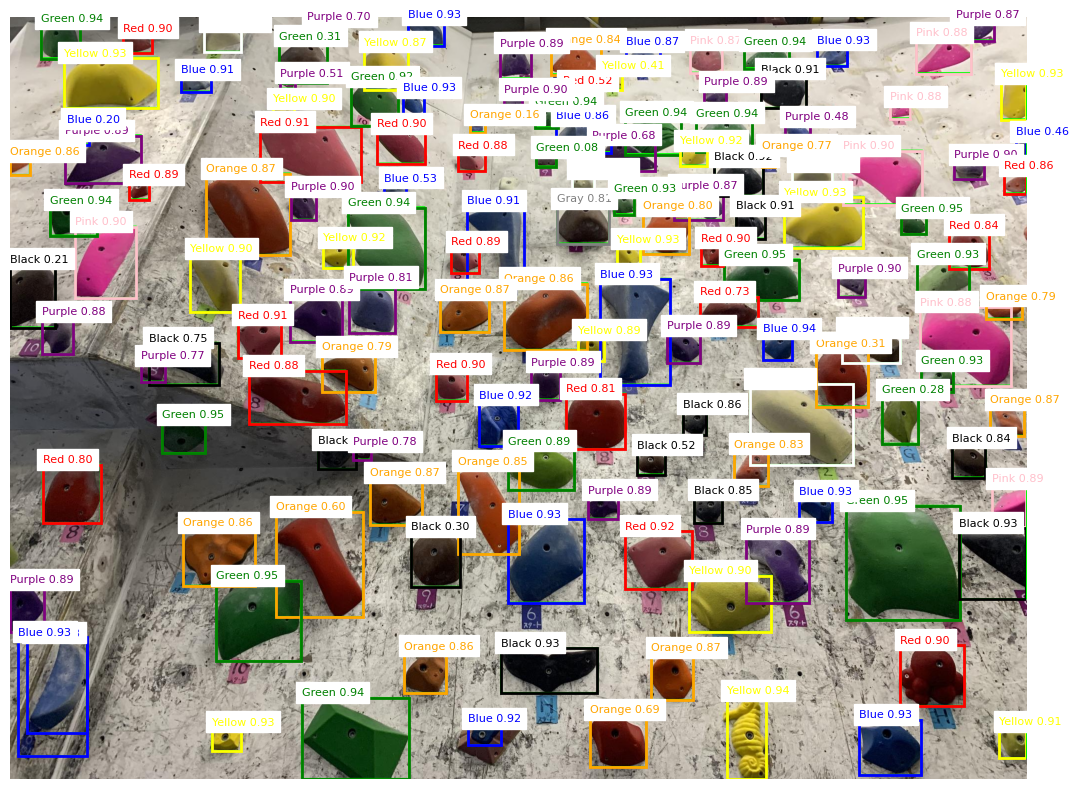

In [15]:
from inference_sdk import InferenceHTTPClient
import tempfile
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

# Initialize the client
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="n8S64aezSPRiiIDZ0fAb"
)

# Lists to store the raw inference results and hold info for visualization
predictions_list = []  # (if you need to refer to them later)
holds_info = []        # each element will contain the coordinates and chosen color

# Process each hold (assume image_rgb and hold_coordinates are defined)
for idx, (x1, y1, x2, y2) in enumerate(tqdm(hold_coordinates, desc="Processing holds")):
    # Crop the sub-image for this hold (image_rgb is in RGB order)
    sub_img = image_rgb[y1:y2, x1:x2]
    
    # Convert to BGR because cv2.imwrite expects BGR
    sub_img_bgr = cv2.cvtColor(sub_img, cv2.COLOR_RGB2BGR)
    
    # Write the sub-image to a temporary file
    with tempfile.NamedTemporaryFile(suffix=".jpg", delete=False) as tmp:
        tmp_path = tmp.name
        cv2.imwrite(tmp_path, sub_img_bgr)
    
    # Call the inference API on the sub-image
    sub_result = CLIENT.infer(tmp_path, model_id="hold-color-detector/1")
    predictions_list.append(sub_result)
    
    # Remove the temporary file
    os.remove(tmp_path)
    
    # Extract predictions and filter out unknown or unlabeled entries
    predictions = sub_result.get("predictions", {})
    if predictions:
        # Filter out entries with labels 'unknown' or 'unlabeled' (case-insensitive) and empty labels
        valid_predictions = {
            color: details for color, details in predictions.items()
            if color.strip() and color.lower() not in ["unknown", "unlabeled"]
        }
        if not valid_predictions:
            continue  # Skip this hold if no valid predictions remain
        
        # Pick the color with the highest confidence from valid predictions
        best_color = max(valid_predictions, key=lambda color: valid_predictions[color].get("confidence", 0))
        confidence = valid_predictions[best_color].get("confidence", 0)
    else:
        continue  # Skip if no predictions were returned

    # Save hold info for later visualization
    holds_info.append({
        "x1": x1,
        "y1": y1,
        "x2": x2,
        "y2": y2,
        "color": best_color,
        "confidence": confidence
    })

# Create a visualization: draw each hold as a rectangle on the original image
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image_rgb)

# Loop over holds_info and add a rectangle for each hold
for hold in holds_info:
    x1, y1, x2, y2 = hold["x1"], hold["y1"], hold["x2"], hold["y2"]
    width, height = x2 - x1, y2 - y1
    color = hold["color"]
    confidence = hold["confidence"]
    
    # Create a rectangle with a 2-pixel-wide edge. We assume the color name is recognized by Matplotlib.
    rect = patches.Rectangle((x1, y1), width, height, linewidth=2,
                             edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    
    # Optionally, annotate the rectangle with the predicted color and its confidence
    ax.text(x1, max(y1 - 5, 0), f"{color} {confidence:.2f}",
            color=color, fontsize=8, backgroundcolor='w')

ax.axis('off')
plt.tight_layout()

# Display the annotated image
plt.show()

# Save the annotated image locally
fig.savefig("./output/annotated_holds.png", dpi=300)


In [13]:
# for each hold print the highest confidence prediction
for hold in holds_info:
    print(f"Hold {hold['x1']}, {hold['y1']}, {hold['x2']}, {hold['y2']}: {hold['color']} {hold['confidence']:.2f}")


Hold 535, 997, 710, 1209: Orange 0.60
Hold 1003, 1012, 1157, 1180: Blue 0.93
Hold 902, 905, 1026, 1083: Orange 0.85
Hold 1684, 985, 1913, 1215: Green 0.95
Hold 415, 1136, 585, 1298: Green 0.95
Hold 1560, 363, 1719, 465: Yellow 0.93
Hold 1834, 585, 2017, 743: Pink 0.88
Hold 1678, 270, 1837, 378: Pink 0.90
Hold 996, 537, 1163, 671: Orange 0.86
Hold 1490, 740, 1699, 903: White 0.79
Hold 395, 316, 564, 480: Orange 0.87
Hold 680, 384, 835, 549: Green 0.94
Hold 1119, 759, 1239, 871: Red 0.81
Hold 349, 1029, 494, 1146: Orange 0.86
Hold 628, 675, 735, 756: Orange 0.79
Hold 65, 902, 182, 1020: Red 0.80
Hold 1239, 1036, 1374, 1152: Red 0.92
Hold 108, 83, 297, 184: Yellow 0.93
Hold 563, 560, 668, 654: Purple 0.89
Hold 1292, 1281, 1376, 1376: Orange 0.87
Hold 1368, 1126, 1534, 1239: Yellow 0.90
Hold 1382, 204, 1495, 272: Green 0.94
Hold 504, 222, 706, 333: Red 0.91
Hold 1794, 1266, 1923, 1388: Red 0.90
Hold 1439, 489, 1590, 571: Green 0.95
Hold 1168, 1406, 1281, 1511: Orange 0.69
Hold 1711, 1416, 